# Import

In [76]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import to_rgba
import numpy as np
import math
import time
from jp_doodle import dual_canvas
from IPython.display import display
import pandas as pd

# Tracking

In [3]:
class TrackingSegment:
    
    def __init__(self, radius, begin, end, hit=0):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.hit = hit
        t = np.linspace(self.begin, self.end, 100)
        self.x = self.radius*np.cos(t)
        self.y = self.radius*np.sin(t)
        
        
    def check_hit(self, particle, orig=False):
        d=particle.radius
        a=(self.radius**2)/(2*d)
        h=math.sqrt(abs(self.radius**2-a**2))
        x2=a*(particle.x)/d   
        y2=a*(particle.y)/d   

        x4=x2-h*(particle.y)/d
        y4=y2+h*(particle.x)/d
        
        theta = np.arctan2(y4,x4)
        
        if theta < 0:
            theta += 2*np.pi
        
        if theta > self.begin and theta < self.end:
            if orig:
                self.hit = 2
            else:
                self.hit = 1
        else:
            self.hit = 0

        return x4, y4
    def get_line(self):
        return self.x, self.y
        
    def draw(self, ax):
        ax.plot(self.x,self.y, color = self.check_color(), linewidth = 4)
        return 
        
    def check_color(self, orig=False):
        if self.hit==2:
            return "red"
        elif self.hit==1:
            return "green"
        else:
            return "black"

# ECL

In [4]:
class ECLSegment:
    def __init__(self, radius, begin, end, width):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.width = width
        self.hit = False
        
    def check_hit(self, particle, orig=False):
        d=particle.radius
        a=(self.radius**2)/(2*d)
        h=math.sqrt(abs(self.radius**2-a**2))
        x2=a*(particle.x)/d   
        y2=a*(particle.y)/d   

        x4=x2-h*(particle.y)/d
        y4=y2+h*(particle.x)/d
        
        theta = np.arctan2(y4,x4)
        
        if theta < 0:
            theta += 2*np.pi
        
        if theta > self.begin and theta < self.end:
            if orig:
                self.hit = 2
            else:
                self.hit = 1
        else:
            self.hit = 0

        return x4, y4
    
    def get_lines(self):
        t = np.linspace(self.begin, self.end, 100)
        inner_x = self.radius*np.cos(t)
        inner_y = self.radius*np.sin(t)
        outer_x = (self.radius+self.width)*np.cos(t)
        outer_y = (self.radius+self.width)*np.sin(t)
        right_x = np.linspace(inner_x[0], outer_x[0], 100)
        right_y = np.linspace(inner_y[0], outer_y[0], 100)
        left_x = np.linspace(inner_x[-1], outer_x[-1], 100)
        left_y = np.linspace(inner_y[-1], outer_y[-1], 100)
        
        return (inner_x, outer_x, right_x, left_x), (inner_y, outer_y, right_y, left_y)
    
    def draw(self, ax):
        t = np.linspace(self.begin, self.end, 100)
        x = self.radius*np.cos(t)
        y = self.radius*np.sin(t)
        ax.plot(x,y, color = self.check_color())
        x_ = (self.radius+self.width)*np.cos(t)
        y_ = (self.radius+self.width)*np.sin(t)
        ax.plot(x_,y_, color = self.check_color())
        ax.plot([x[0], x_[0]], [y[0], y_[0]], color = self.check_color())
        ax.plot([x[-1], x_[-1]], [y[-1], y_[-1]], color = self.check_color())
        return 
        
    def check_color(self):
        if self.hit==2:
            return "red"
        elif self.hit==1:
            return "green"
        else:
            return "black"

In [5]:
class Tracking:
    def __init__(self, layers, n_segments, k = 2):
        self.n_segments = n_segments
        self.layers = []
        for l in range(layers):
            self.layers.append([])
            len_segment = 2*np.pi/(n_segments+k*l)
            for i in range(n_segments+k*l):
                #print(l, i, round(len_segment*i+(0.2/(l+1)), 3), round(len_segment*(i+1)-(0.2)/(l+1), 3))
                self.layers[l].append(TrackingSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1)))
        self.ecl = []
        l = len(self.layers)
        len_segment = 2*np.pi/(n_segments+k*l)
        for i in range(n_segments+k*l):
            self.ecl.append(ECLSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1), width = 1))
        # if orig_particle is not None:
        #     for l in self.layers:
        #         for s in l:
        #             s.check_hit(orig_particle)
    
    def make_collections(self, particle, orig_particle=None):
        coord = []
        size = []
        c = []
        for layer in self.layers:
            for segment in layer:
                line_x, line_y = segment.get_line()
                coord.append([line_x,line_y])
                segment.check_hit(particle)
                
                if (orig_particle is not None) & (not segment.hit):
                    segment.check_hit(orig_particle, orig=True)
                    # c.append(segment.check_color(orig=True))
                c.append(segment.check_color())
                size.append(2)
        for crystal in self.ecl:
            lines_x, lines_y = crystal.get_lines()
            for l_x, l_y in zip(lines_x, lines_y):
                coord.append([l_x,l_y])
                crystal.check_hit(particle)
                if (orig_particle is not None) & (not crystal.hit):
                    crystal.check_hit(orig_particle, orig=True)
                c.append(crystal.check_color())
                size.append(1)
        coord = np.array(coord)
        coord = np.moveaxis(coord,1,-1)
        line_collection = LineCollection(coord, color = c, linewidths = size)
        return line_collection
    
    def draw_collection(self, ax, particle, orig_particle=None):
        line_collection = self.make_collections(particle, orig_particle=orig_particle)
        ax.add_collection(line_collection)
        # if orig_particle is not None:
        #     orig_line_collection = self.make_collections(orig_particle)
        #     ax.add_collection(orig_line_collection)
        
        
    def draw(self, ax, particle):
        for l in self.layers:
            for s in l:
                s.check_hit(particle)
                s.draw(ax)
        for e in self.ecl:
            e.draw(ax)

# Particle

In [6]:
class Particle:
    def __init__(self,r, phi, B=1., charge=1.):
        self.x = abs(r)*np.cos(phi)
        self.y = abs(r)*np.sin(phi)
        self.radius = r
        self.phi = phi
        self.B = B
        self.charge = charge
        
    def momentum(self):
        return abs(self.radius) * self.B * abs(self.charge)
    
    def draw(self, ax):
        offset = np.pi if self.radius<0 else 0
        self.x = abs(self.radius)*np.cos(self.phi)
        self.y = abs(self.radius)*np.sin(self.phi)
        theta = np.linspace(0,np.pi,100)
        x = abs(self.radius)*np.cos(theta+self.phi + offset)+self.x
        y = abs(self.radius)*np.sin(theta+self.phi + offset)+self.y
        c = "blue" if self.radius<0 else "red"
        self.lines = ax.plot(x,y,color = c, label=f'p = {self.momentum()} GeV')
        plt.legend()

# Track reco

In [1]:
def track_values(p, charge=1., B=1.):
    return p/(charge*B)

In [ ]:
# load in data

data = pd.read_hdf('EEEE/0_allcomb_0.h5')
coords = [f'{i}' for i in np.arange(0, 6624)]
hits = data[coords]
momenta = data[['phi', 'pt']]
momenta['charge'] = data['pdg']/abs(data['pdg'])
momenta['phi'] = momenta['phi']*np.pi/180.

interactive(children=(FloatSlider(value=10.0, description='r', min=-100.0, step=0.2), FloatSlider(value=0.0, d…

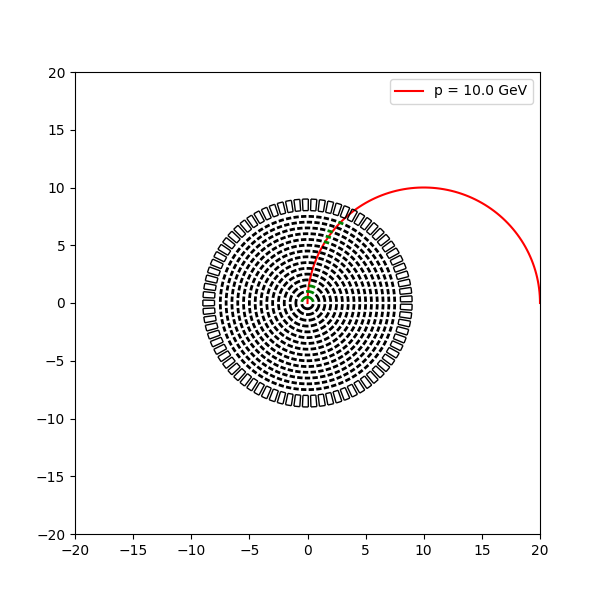

In [7]:
# set up plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim([-20,20])
ax.set_xlim([-20,20])

# generate x values
x = np.linspace(0, 2 * np.pi, 100)

# radius = track_values(, charge=-1., B=0.2)
 
B = 0.1
momenta['radius'] = track_values(momenta['pt'], charge=momenta['charge'], B=B)
particle = Particle(5,0, B=B, charge=-1.)

chosen_particle = momenta.iloc[1]
# print(chosen_particle
original_particle = Particle(chosen_particle['radius'].item(), 
                             chosen_particle['phi'].item(), 
                             B=B, 
                             charge=chosen_particle['charge'].item())


tracking = Tracking(15,2, k = 2)
@widgets.interact(phi = (-np.pi,np.pi, 0.1), r = (-50,50,0.1))
def update(r=5, phi = 0):
    """Remove old lines from plot and plot new one"""
    if r != 0 :
        particle.radius = r
        particle.phi = phi
        [l.remove() for l in ax.lines]
        particle.draw(ax)
        # tracking.draw_collection(ax, original_particle)
        tracking.draw_collection(ax, particle, orig_particle=original_particle)
        

In [ ]:
#trying to calculate ecl hit, ignore this please
def find_crystal(radius, phi):
    x = radius*np.cos(phi)
    y = radius*np.sin(phi)
    d=math.sqrt(x**2 + y**2)
    a=(139**2-radius**2+d**2)/(2*d)
    h=math.sqrt(abs(radius**2-a**2))
    x2=a*(x)/d   
    y2=a*(y)/d   
    x3=x2+h*(y)/d     
    y3=y2-h*(x)/d 

    x4=x2-h*(y)/d
    y4=y2+h*(x)/d


    rho = math.sqrt(x4**2 + y4**2)
    theta = np.arctan2(y4,x4)

    if theta < 0:
        theta += 2*np.pi
        
    return theta

radius = 21.0
phi = 2.86

find_crystal(radius, phi)

In [77]:
class ECLCrystal:
    def __init__(self, x, y, edge, hit=False):
        self.x = x
        self.y = y
        self.edge = edge
        self.hit = hit
        self.chosen = False
        self.facecolor = to_rgba("white")
        self.edgecolor = to_rgba("black")
        
    def draw(self,ax):
        ax.add_patch(Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = self.edgecolor, facecolor = self.check_color(), linewidth = 1))
        
    def get_patch(self):
        return Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = self.edgecolor, facecolor = self.check_color(), linewidth = 1)
    
    def check_color(self):
        if self.chosen:
            return "red"
        elif self.hit:
            return "red"
        else:
            return "grey"

In [93]:
class ECal:
    def __init__(self, nrows, ncols, hits, crystal_edge = 1):
        self.crystals = np.empty((nrows, ncols), dtype = ECLCrystal)
        hit = False
        #he did this just to confuse the fuck out of me
        for c in range(ncols):
            for r in range(nrows):
                if hits[144*c+r] > 0.0:
                    hit = True
                self.crystals[r,c] = ECLCrystal(r*crystal_edge, c*crystal_edge, crystal_edge-0.2, hit=hit)
                hit = False
    
    def draw(self, ax):
        for r in self.crystals:
            for c in r:
                c.draw(ax)
    
    def draw_collection(self,ax):
        ax.add_collection(self.collection)
                
    def get_coords(self):
        coords = []
        for cols in self.crystals:
            for crystal in cols:
                coords.append([crystal.x, crystal.y])
        return coords
    
    def get_collection(self):
        crystals = []
        for c in self.crystals.flatten():
            crystals.append(c.get_patch())
        self.collection = PatchCollection(crystals, match_original=True)
        return self.collection
    
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crystals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

## V2

In [143]:
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path


class SelectFromCollection:

    def __init__(self, ax, ecal):
        self.canvas = ax.figure.canvas
        self.ecal = ecal    
        
        xy = np.array(ecal.get_coords()).T      
        self.ecal.get_collection()
        self.ecal.draw_collection(ax)
        self.collection = ax.scatter(xy[0], xy[1], s=0)
        self.xys = self.collection.get_offsets()
        self.Npts = len(self.xys)
    
        # Ensure that we have separate colors for each object
        self.fc = self.ecal.collection.get_edgecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:] = to_rgba("Black")
        self.fc[self.ind] = to_rgba("green")
        self.ecal.collection.set_edgecolors(self.fc)
        self.canvas.draw_idle()

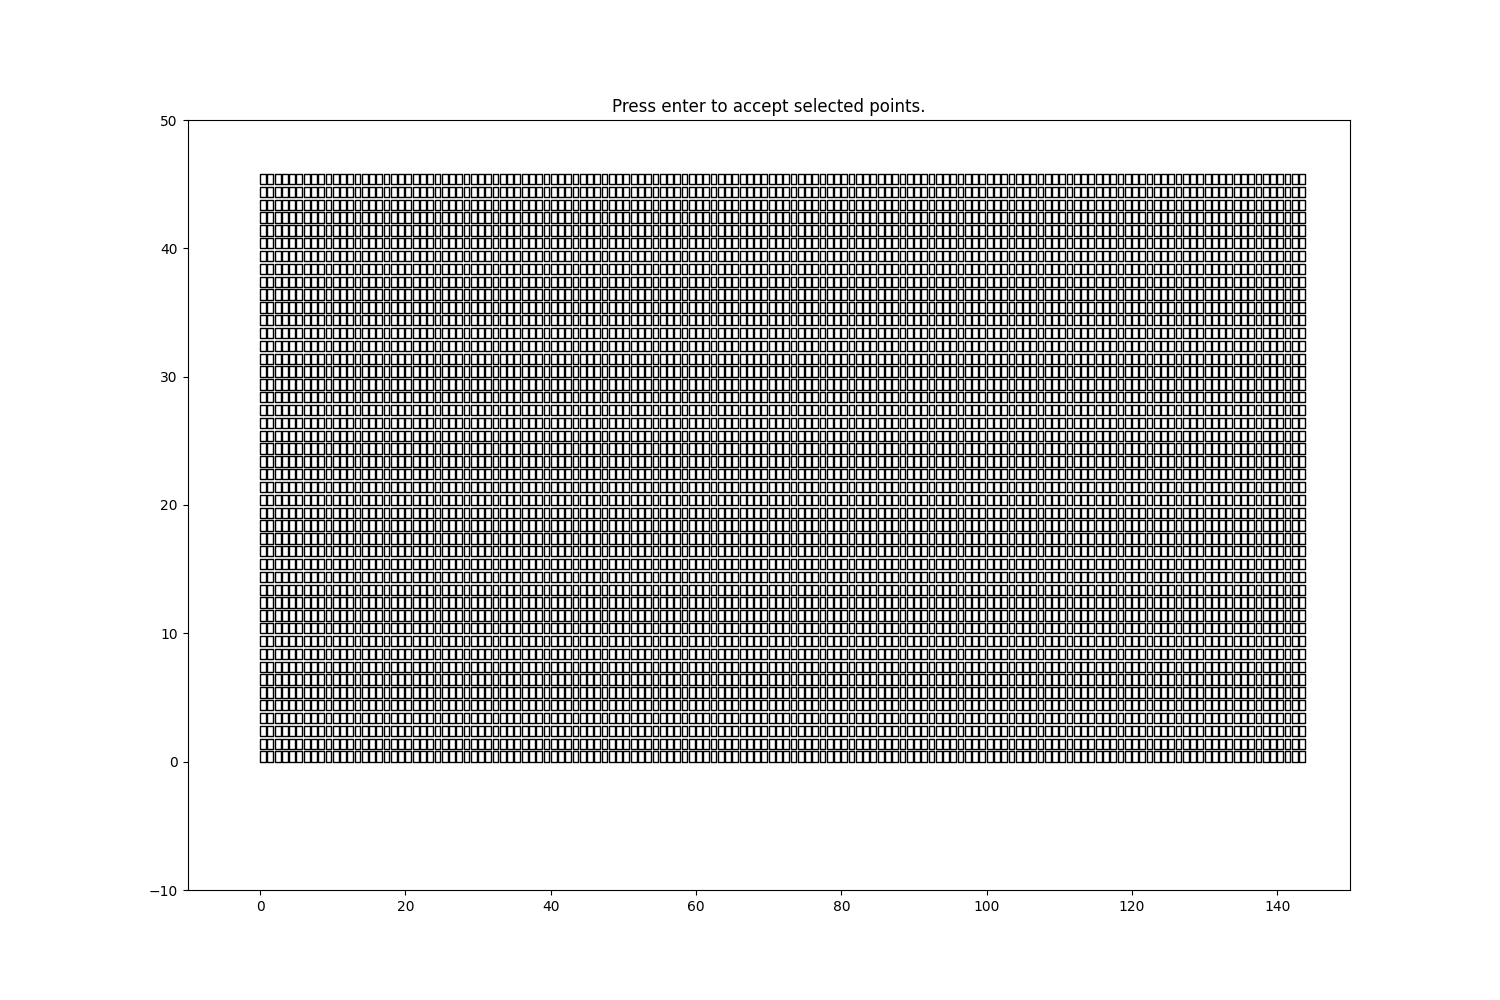

In [144]:
ecal = ECal(144,46,hits.iloc[0].to_numpy())
subplot_kw = dict(xlim=(-10,150), ylim=(-10,50), autoscale_on=False)
fig, ax = plt.subplots(figsize=(15,10), subplot_kw=subplot_kw)

selector = SelectFromCollection(ax, ecal)
#selector.onselect([[0,10],[10,10],[9,10],[0,1]])

def accept(event):
    if event.key == "enter":
        print("Selected points:")
        print(selector.xys[selector.ind])
        selector.disconnect()
        ax.set_title("")
        fig.canvas.draw()

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")

plt.show()

In [92]:
ecal.collection.get_facecolors()

array([[0.12156863, 0.46666667, 0.70588235, 1.        ]])